## Correlating FERC and EIA Plants

FERC and EIA report plants somewhat differently. In order to use the two datasets in tandem (e.g. to use FERC Form 1 O&M costs alongside EIA 923 boiler and generator level fuel consumption and net generation) we need to link the two sets of plants together.

There are several variables which are reported by both FERC and EIA, or which are derivable from reported values. These include:
* Yearly total heat content of fuel consumed by plant and by fuel.
* Yearly total cost of fuel consumed by plant and by fuel.
* Yearly net electricity generation by plant.

Given these data, it may be possible to infer associations between a given collection of EIA boilers and generators, and the corresponding plant-level data from FERC.

This notebook looks at the correlations between the above listed variables for the FERC and EIA datasets as a whole, first for the simplest plants -- those with only a single unit reported in both FERC and EIA, and grouped under a common PUDL plant ID.

Given high correlations between these variables, we then look at the correlations within individual simple plants -- can we effectively differentiate between a good and a bad plant-level match, even for the simple plants, given just a handful of years for each one?

If we can identify good and bad matches for simple plants, then we can move on to more complicated types of plants, where we may need to select some subset of plants, boilers, and generators to associate with individual FERC plants that we have grouped under a single PUDL plant ID, based on how well the variables for different collections of infrastructure correlate.

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..','..')))
from pudl import pudl, ferc1, eia923, settings, constants
from pudl import models, models_ferc1, models_eia923
from pudl import clean_eia923, clean_ferc1, clean_pudl
from pudl import analysis
import numpy as np
import pandas as pd
import sqlalchemy as sa
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
%load_ext autoreload
%autoreload
pudl_engine = pudl.connect_db()

# Merging FERC & EIA DataFrames
These next few functions merge data from the above dataframs into single DataFrames that are ready for plotting the quantities of interest.

In [2]:
def pudl_plant_fuel_consumed(pudl_plant_ids, pudl_engine, fuels=['gas','oil','coal']):
    """Calculate total annual fuel consumption for a list of PUDL plants.
    For each pudl_plant_id provided, calculate the total heat content of fuel
    consumed, for each specified type of fuel.
    Do separate tallies based on the EIA923 and FERC1 datasets.
    
    DataFrame Fields:
    - pudl_plant_id
    - year
    - fuel
    - mmbtu_eia923
    - mmbtu_ferc1
    """
    # This gives us a DataFrame with annual total fuel consumed (and net generation)
    # with report_year, PUDL plant ID and fuel information.
    gf_totals_df = analysis.gen_fuel_by_pudl(pudl_plant_ids, pudl_engine,
                                             fuels=fuels, cols=['fuel_consumed_total_mmbtu',])
    gf_totals_df = gf_totals_df.rename(columns={'fuel_consumed_total_mmbtu':'mmbtu_eia923'})
    
    # Now we need to grab the analogous information from FERC Form 1:
    fuel_totals_df = analysis.fuel_ferc1_by_pudl(pudl_plant_ids, pudl_engine, fuels=fuels)
    fuel_totals_df = fuel_totals_df.drop(['fuel_consumed_total_cost_mmbtu','fuel_consumed_total_cost_unit'], axis=1)
    fuel_totals_df = fuel_totals_df.rename(columns={'fuel_consumed_total_mmbtu':'mmbtu_ferc1'})

    return(pd.merge(gf_totals_df, fuel_totals_df, on=['plant_id_pudl','report_year','fuel']))

In [3]:
def pudl_plant_net_generation(pudl_plant_ids, pudl_engine):
    """Calculate total annual net generation for a list of PUDL plants.
    
    DataFrame Fields:
    - pudl_plant_id
    - year
    - mwh_eia923
    - mwh_ferc1
    """
    # This gives us a DataFrame with annual total fuel consumed (and net generation)
    # with report_year, PUDL plant ID and fuel information.
    gf_totals_df = analysis.gen_fuel_by_pudl(pudl_plant_ids, pudl_engine, fuels='all', cols=['net_generation_mwh',])
    gf_totals_df = gf_totals_df.rename(columns={'net_generation_mwh':'mwh_eia923'})
    
    steam_totals_df = analysis.steam_ferc1_by_pudl(pudl_plant_ids, pudl_engine, cols=['net_generation_mwh'])
    steam_totals_df = steam_totals_df.rename(columns={'net_generation_mwh':'mwh_ferc1'})

    return(pd.merge(gf_totals_df, steam_totals_df, on=['plant_id_pudl','report_year']))

In [4]:
def pudl_plant_fuel_cost(pudl_plant_ids, pudl_engine, fuels=['gas','oil','coal']):
    """Calculate total annual fuel costs, on a per fuel and per-PUDL plant basis
    
    DataFrame Fields:
    - pudl_plant_id
    - year
    - fuel
    - cost_eia923
    - cost_mmbtu_ferc1
    - cost_unit_ferc1
    """
    # EIA 923 fuel cost data comes from the fuel_receipts_costs table.
    # This data can be broken out by fuel type.
    frc_totals_df = analysis.frc_by_pudl(pudl_plant_ids, pudl_engine, fuels=fuels)
    
    frc_totals_df = frc_totals_df.rename(columns={'total_fuel_cost':'cost_eia923'})
    
    # There are several ways to get fuel costs from FERC Form 1
    # per-unit and per-mmbtu fuel costs are reported in f1_fuel,
    # along with the total units and total heat content consumed.
    fuel_totals_df = analysis.fuel_ferc1_by_pudl(pudl_plant_ids, pudl_engine, fuels=fuels)
    fuel_totals_df = fuel_totals_df.drop('fuel_consumed_total_mmbtu', axis=1)
    fuel_totals_df = fuel_totals_df.rename(columns={'fuel_consumed_total_cost_mmbtu':'cost_mmbtu_ferc1',
                                                    'fuel_consumed_total_cost_unit':'cost_unit_ferc1'})
    
    return(pd.merge(frc_totals_df, fuel_totals_df, on=['plant_id_pudl','fuel','report_year']))

# Pulling it all together.
Here we actually select some plants, specify the fuels of interest, and pull the data for each of the three families of variables we're trying to compare... before moving on to doing some plotting!

In [5]:
#pudl_plants = analysis.simple_pudl_plant_ids(pudl_engine)
pudl_plants = analysis.ferc_eia_shared_plant_ids(pudl_engine)
fuels = ['gas','oil','coal']

fuel_eia923_ferc1 = pudl_plant_fuel_consumed(pudl_plants, pudl_engine, fuels=fuels)
netgen_eia923_ferc1 = pudl_plant_net_generation(pudl_plants, pudl_engine)
cost_eia923_ferc1 = pudl_plant_fuel_cost(pudl_plants, pudl_engine, fuels=fuels)

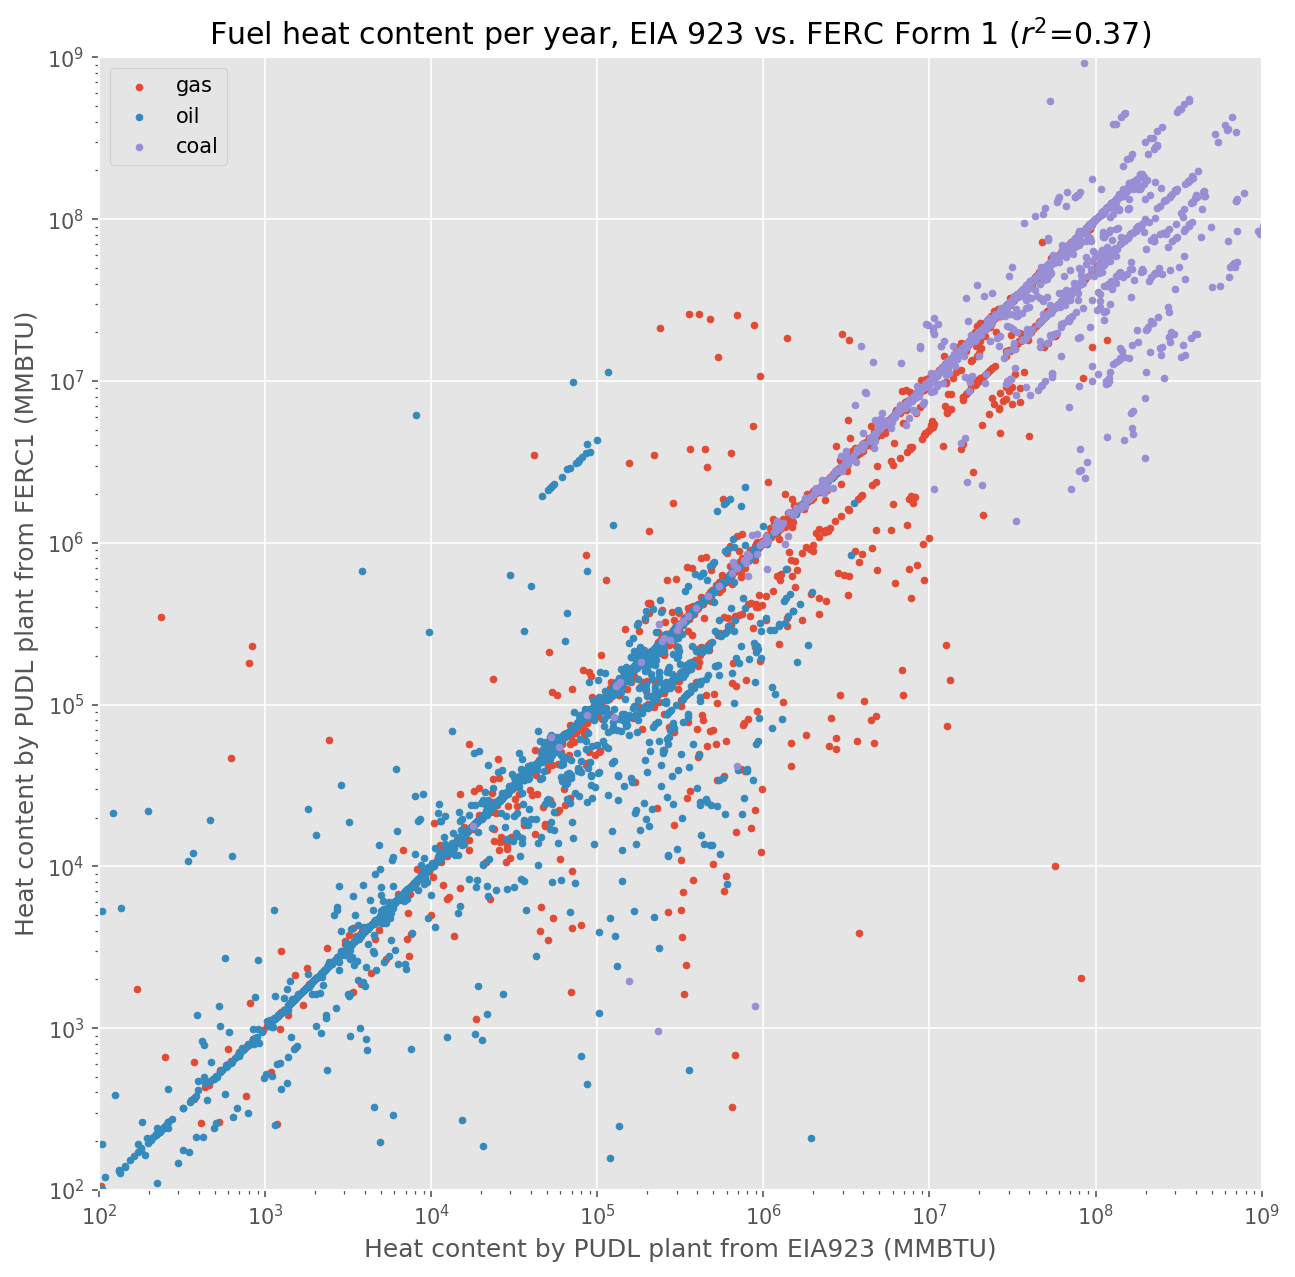

In [6]:
fig, (ax) = plt.subplots(ncols=1, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(10)
fig.set_dpi(150)
ax.loglog()
plt.ylim(100,1e9)
plt.xlim(100,1e9)
plt.grid(b=True)
for fuel in fuels:
    ax.scatter(fuel_eia923_ferc1[(fuel_eia923_ferc1.fuel==fuel)]['mmbtu_eia923'],
               fuel_eia923_ferc1[(fuel_eia923_ferc1.fuel==fuel)]['mmbtu_ferc1'],
               label=fuel, s=10)
ax.legend(loc='upper left')
R2 = np.corrcoef(fuel_eia923_ferc1.mmbtu_eia923, fuel_eia923_ferc1.mmbtu_ferc1)[0,1]**2
plt.title("Fuel heat content per year, EIA 923 vs. FERC Form 1 ($r^2$={:.2f})".format(R2))
plt.xlabel("Heat content by PUDL plant from EIA923 (MMBTU)")
plt.ylabel("Heat content by PUDL plant from FERC1 (MMBTU)")
plt.show();

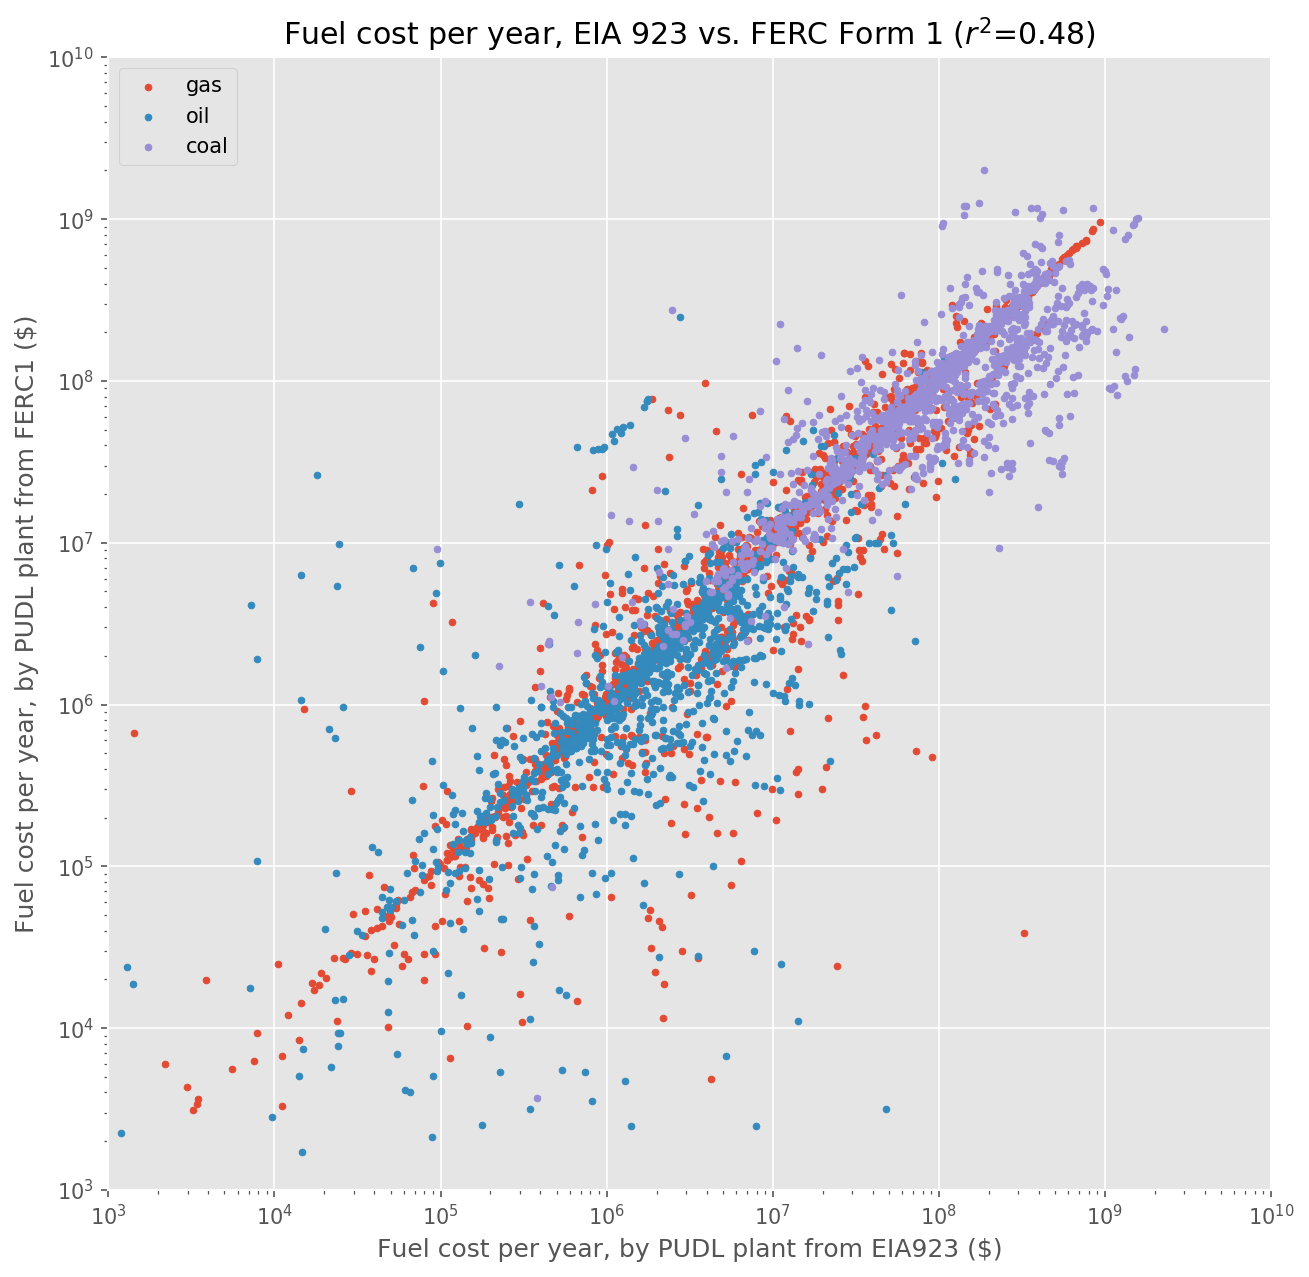

In [7]:
fig, (ax) = plt.subplots(ncols=1, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(10)
fig.set_dpi(150)
ax.loglog()
plt.ylim(1e3,1e10)
plt.xlim(1e3,1e10)
plt.grid(b=True)
for fuel in fuels:
    ax.scatter(cost_eia923_ferc1[(cost_eia923_ferc1.fuel==fuel)]['cost_eia923'],
               cost_eia923_ferc1[(cost_eia923_ferc1.fuel==fuel)]['cost_mmbtu_ferc1'],
               label=fuel, s=10)
ax.legend(loc='upper left')
R2 = np.corrcoef(cost_eia923_ferc1.cost_eia923, cost_eia923_ferc1.cost_mmbtu_ferc1)[0,1]**2
plt.title("Fuel cost per year, EIA 923 vs. FERC Form 1 ($r^2$={:.2f})".format(R2))
plt.xlabel("Fuel cost per year, by PUDL plant from EIA923 ($)")
plt.ylabel("Fuel cost per year, by PUDL plant from FERC1 ($)")
plt.show();

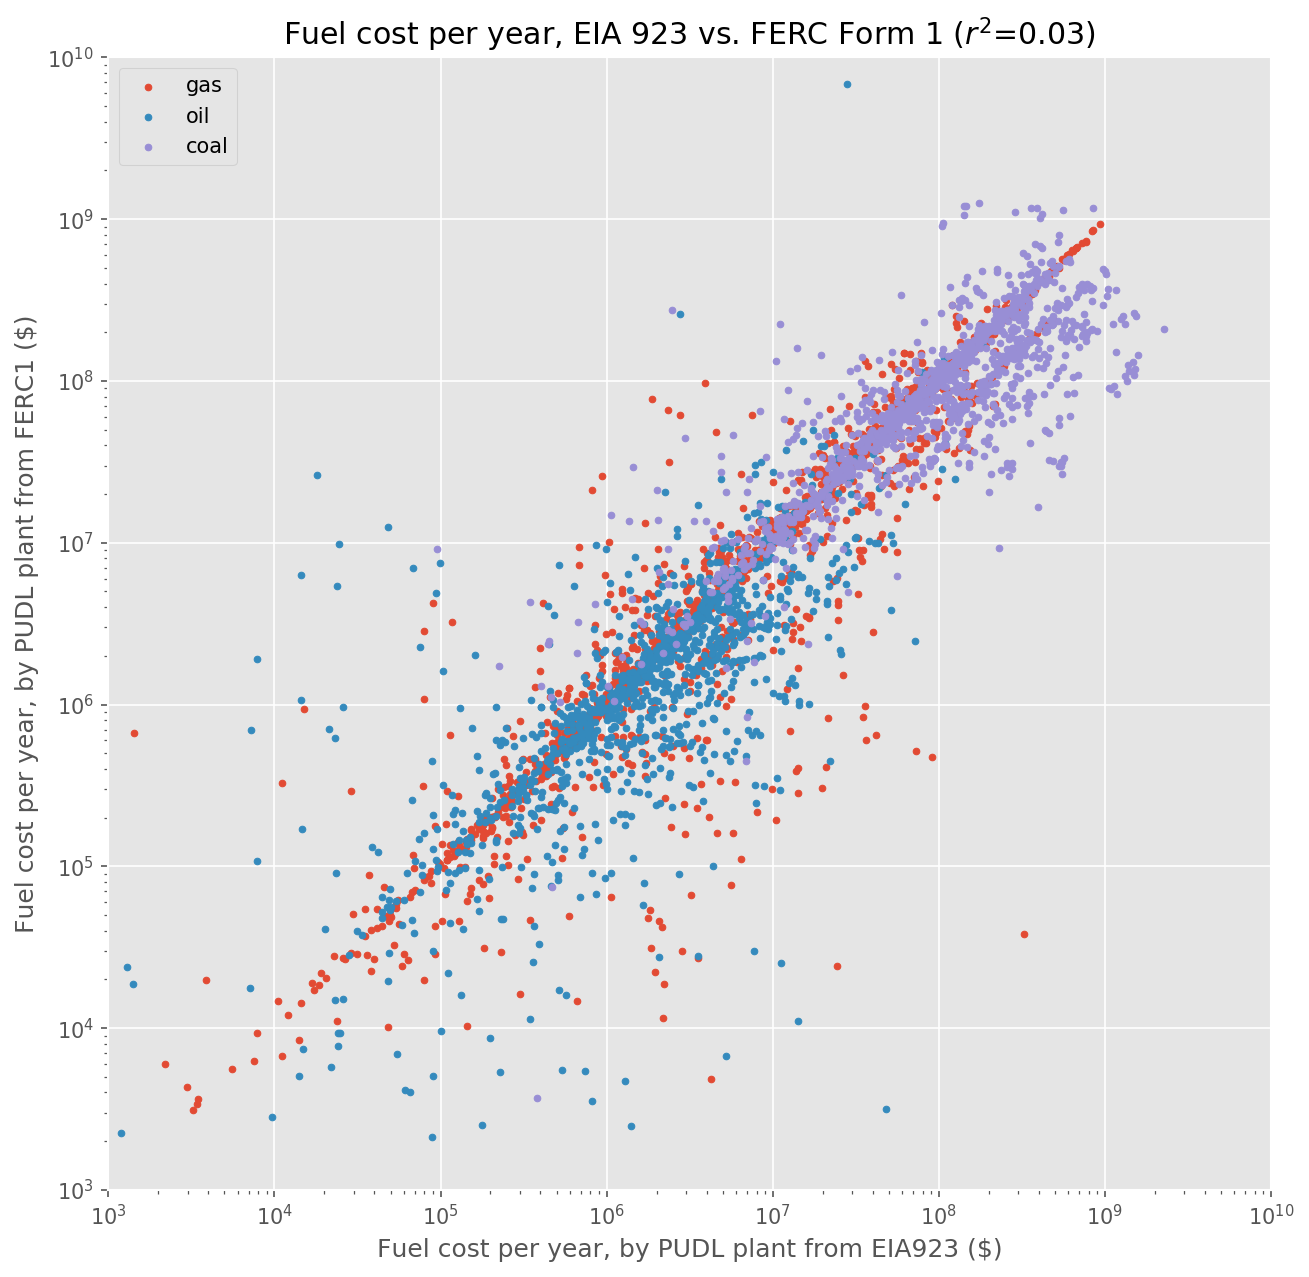

In [8]:
fig, (ax) = plt.subplots(ncols=1, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(10)
fig.set_dpi(150)
ax.loglog()
plt.ylim(1e3,1e10)
plt.xlim(1e3,1e10)
plt.grid(b=True)
for fuel in fuels:
    ax.scatter(cost_eia923_ferc1[(cost_eia923_ferc1.fuel==fuel)]['cost_eia923'],
               cost_eia923_ferc1[(cost_eia923_ferc1.fuel==fuel)]['cost_unit_ferc1'],
               label=fuel, s=10)
ax.legend(loc='upper left')
R2 = np.corrcoef(cost_eia923_ferc1.cost_eia923, cost_eia923_ferc1.cost_unit_ferc1)[0,1]**2
plt.title("Fuel cost per year, EIA 923 vs. FERC Form 1 ($r^2$={:.2f})".format(R2))
plt.xlabel("Fuel cost per year, by PUDL plant from EIA923 ($)")
plt.ylabel("Fuel cost per year, by PUDL plant from FERC1 ($)")
plt.show();

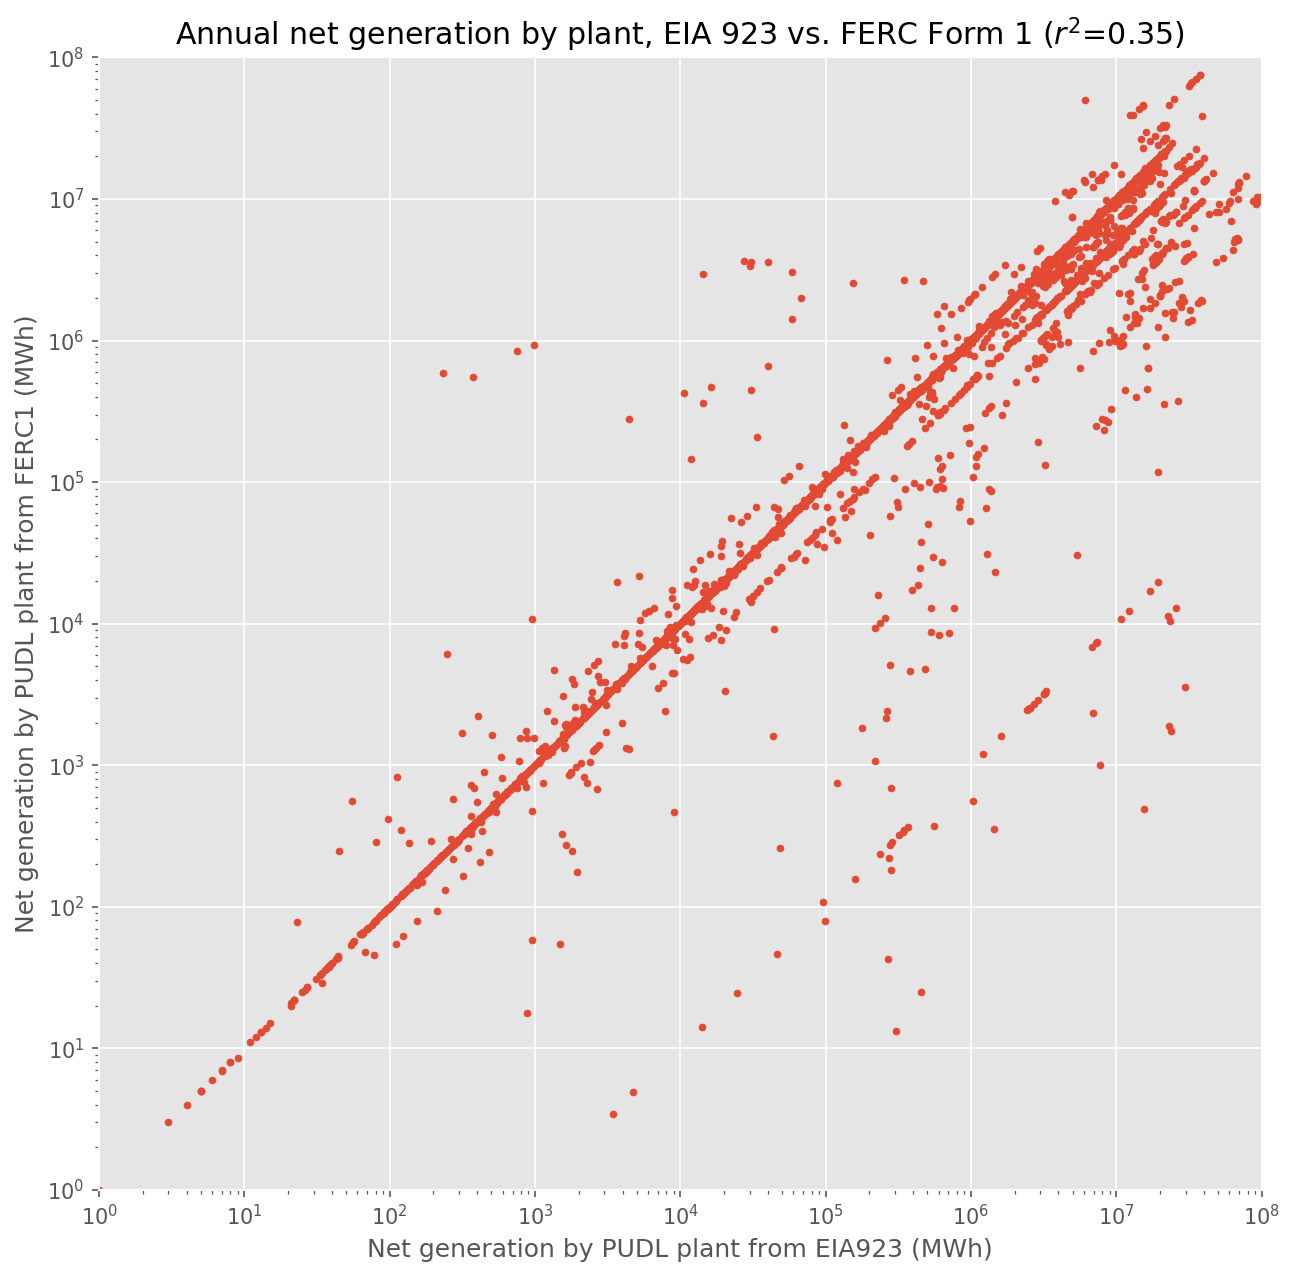

In [9]:
fig, (ax) = plt.subplots(ncols=1, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(10)
fig.set_dpi(150)
ax.loglog()
plt.ylim(1,1e8)
plt.xlim(1,1e8)
plt.grid(b=True)
R2 = np.corrcoef(netgen_eia923_ferc1.mwh_eia923, netgen_eia923_ferc1.mwh_ferc1)[0,1]**2
ax.scatter(netgen_eia923_ferc1['mwh_eia923'],
           netgen_eia923_ferc1['mwh_ferc1'],
           s=10)
plt.title("Annual net generation by plant, EIA 923 vs. FERC Form 1 ($r^2$={:.2f})".format(R2))
plt.xlabel("Net generation by PUDL plant from EIA923 (MWh)")
plt.ylabel("Net generation by PUDL plant from FERC1 (MWh)")
plt.show();

# Plant-by-Plant Correlations
Given that the entire datasets seem to correlate pretty well, now we want to look at each plant individually, and see whether it is easy to identify well an poorly matched plants.

In [10]:
def plant_corr(pudl_df, x1, x2):
    gb = pudl_df.groupby('plant_id_pudl')
    corr = gb[[x1,x2]].corr().reset_index()
    corr = corr.drop(x2, axis=1)
    corr = corr[corr['level_1']==x2]
    corr = corr[['plant_id_pudl',x1]]
    corr = corr.rename(columns={x1:'corr'})
    corr = corr.dropna()
    return(corr)

def plot_plant_corr(corrs=[], titles=[]):
    """Given a list of DataFrames containing per-plant correlations of some variable,
    and a set of associated figure titles, create a figure displaying the distributions
    of those correlations."""
    
    nrows = len(corrs)
    assert nrows == len(titles)
    fig, axes = plt.subplots(ncols=1, nrows=nrows)
    fig.set_figwidth(10)
    fig.set_figheight(4*nrows)
    fig.set_dpi(150)
    for (ax, title, corr) in zip(axes, titles, corrs):
        ax.set_xlim(0.0,1.1)
        ax.set_title(title)
        ax.set_ylabel("# of Plants")
        ax.set_xlabel("$R^2$")
        ax.grid(b=True)
        ax.hist(corr['corr']**2, bins=250);
    fig.tight_layout()
    plt.show()

In [11]:
netgen_eia923_ferc1[netgen_eia923_ferc1.plant_id_pudl==3]

,plant_id_pudl,mwh_eia923,report_year,mwh_ferc1
2,3,3462031.000,2009,2991157.0
551,3,4847270.000,2010,4191341.0
1122,3,4721913.980,2011,4070629.0
1691,3,4323455.007,2012,3718244.0
2268,3,4936145.011,2013,4243611.0
2835,3,5084652.026,2014,4375653.0
3401,3,4583205.997,2015,3965867.0
3949,3,5087735.026,2016,4373477.0


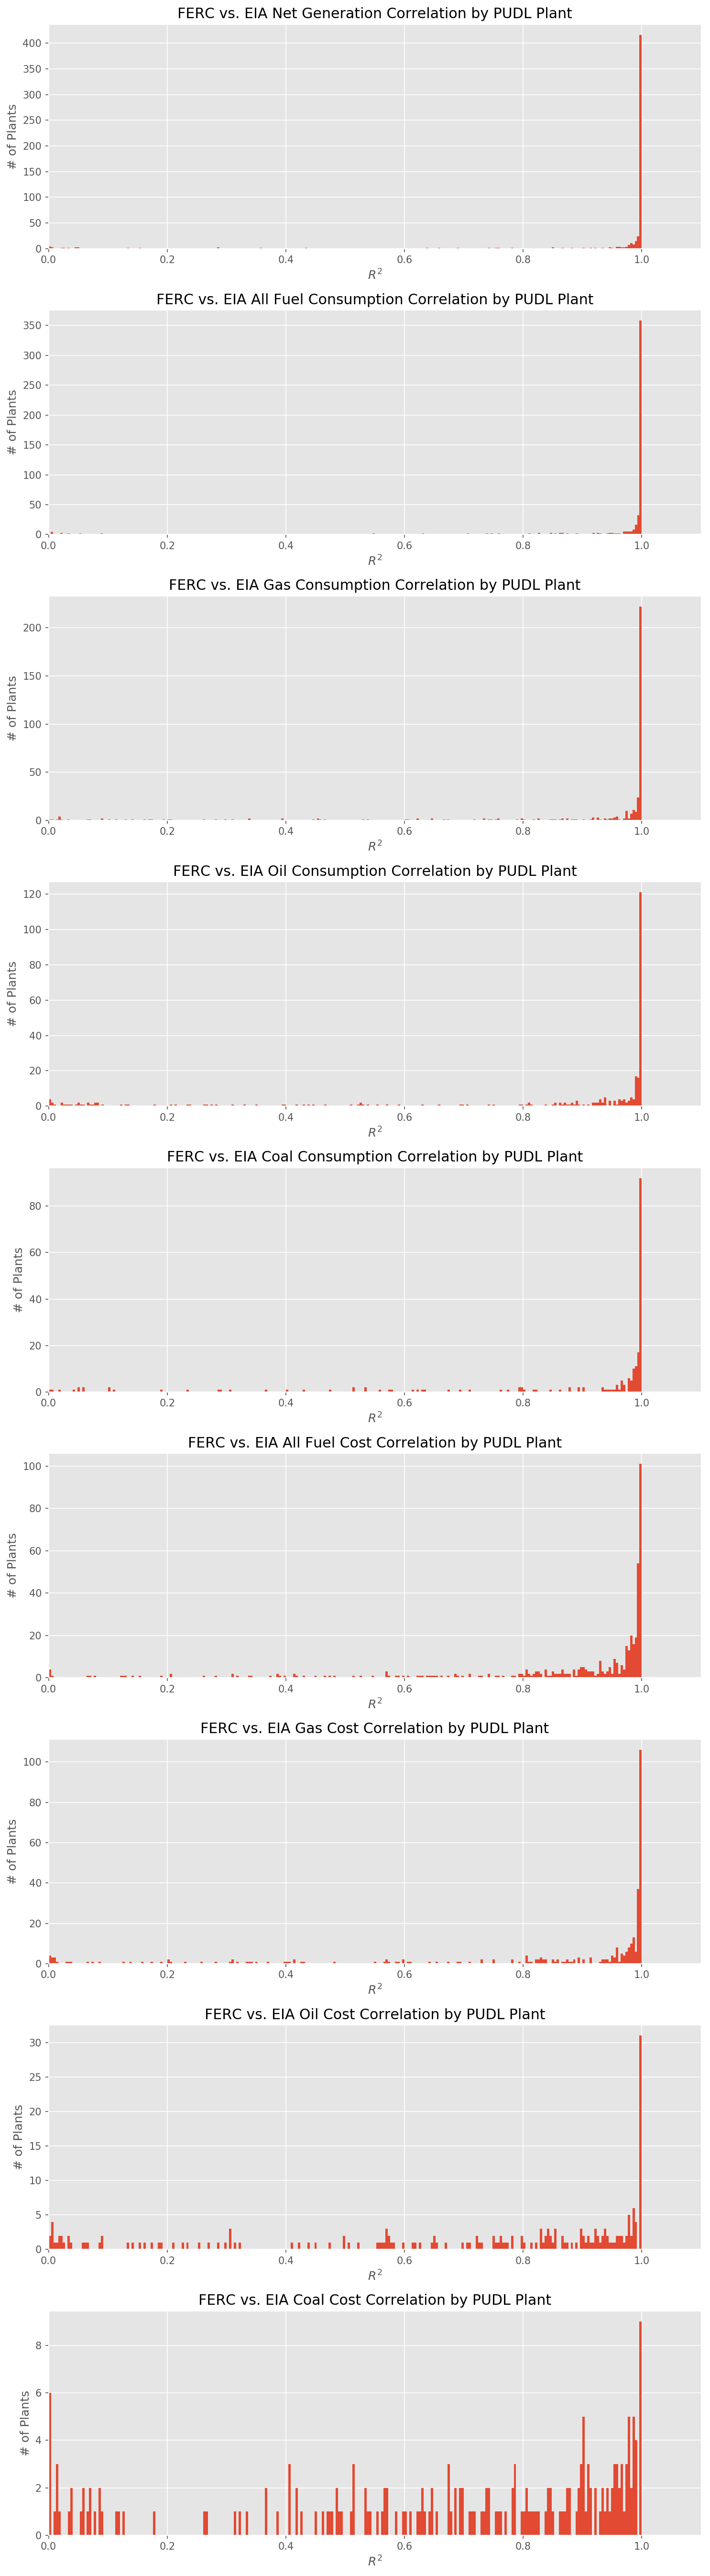

In [12]:
netgen_corr = plant_corr(netgen_eia923_ferc1, 'mwh_eia923', 'mwh_ferc1')
fuel_corr = plant_corr(fuel_eia923_ferc1, 'mmbtu_eia923', 'mmbtu_ferc1')

gas_fuel_corr = plant_corr(fuel_eia923_ferc1[fuel_eia923_ferc1['fuel']=='gas'], 'mmbtu_eia923', 'mmbtu_ferc1')
oil_fuel_corr = plant_corr(fuel_eia923_ferc1[fuel_eia923_ferc1['fuel']=='oil'], 'mmbtu_eia923', 'mmbtu_ferc1')
coal_fuel_corr = plant_corr(fuel_eia923_ferc1[fuel_eia923_ferc1['fuel']=='coal'], 'mmbtu_eia923', 'mmbtu_ferc1')

cost_corr = plant_corr(cost_eia923_ferc1, 'cost_eia923','cost_mmbtu_ferc1')

gas_cost_corr = plant_corr(cost_eia923_ferc1[cost_eia923_ferc1['fuel']=='gas'], 'cost_eia923', 'cost_mmbtu_ferc1')
oil_cost_corr = plant_corr(cost_eia923_ferc1[cost_eia923_ferc1['fuel']=='oil'], 'cost_eia923', 'cost_mmbtu_ferc1')
coal_cost_corr = plant_corr(cost_eia923_ferc1[cost_eia923_ferc1['fuel']=='coal'], 'cost_eia923', 'cost_mmbtu_ferc1')

corrs = [netgen_corr,
         fuel_corr,
         gas_fuel_corr,
         oil_fuel_corr,
         coal_fuel_corr,
         cost_corr,
         gas_cost_corr,
         oil_cost_corr,
         coal_cost_corr]
titles = ['FERC vs. EIA Net Generation Correlation by PUDL Plant',
          'FERC vs. EIA All Fuel Consumption Correlation by PUDL Plant',
          'FERC vs. EIA Gas Consumption Correlation by PUDL Plant',
          'FERC vs. EIA Oil Consumption Correlation by PUDL Plant',
          'FERC vs. EIA Coal Consumption Correlation by PUDL Plant',
          'FERC vs. EIA All Fuel Cost Correlation by PUDL Plant',
          'FERC vs. EIA Gas Cost Correlation by PUDL Plant',
          'FERC vs. EIA Oil Cost Correlation by PUDL Plant',
          'FERC vs. EIA Coal Cost Correlation by PUDL Plant']
plot_plant_corr(corrs, titles)